<a href="https://colab.research.google.com/github/kushalnavghare/DSC-478_PRG_ML_APP/blob/main/Assignment_2_DSC_478.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
## Name: Kushal Navghare
## Student ID: 2116916

For this assignment you will experiment with various classification models using subsets of some real-world data sets. In particular, you will use the K-Nearest-Neighbor algorithm to classify text documents, experiment with and compare classifiers that are part of the scikit-learn machine learning package for Python, and use some additional preprocessing capabilities of pandas and scikit-learn packages.

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
%cd drive/MyDrive/DSC-478_PRG_ML_APPS

[Errno 2] No such file or directory: 'drive/MyDrive/DSC-478_PRG_ML_APPS'
/content/drive/MyDrive/DSC-478_PRG_ML_APPS


In [118]:
%pwd

'/content/drive/My Drive/DSC-478_PRG_ML_APPS'

# 1.	K-Nearest-Neighbor (KNN) classification on Newsgroups [Dataset: [newsgroups.zip](https://http://facweb.cs.depaul.edu/mobasher/classes/CSC478/Data/newsgroups.zip)]

Your tasks in this problem are the following [Note: for this problem you should not use scikit-learn for classification, but implement your own KNN classifier. You may use Pandas, NumPy, standard Python libraries, and Matplotlib.]

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [120]:
import warnings
warnings.filterwarnings(action='ignore')

## a
Load the data sets, including the train and test matrices as well as the train and test labels. Show the top 20 terms in the decreasing order of total training frequency (total number of occurences of the term across all documents in the training data). Then plot the distribtution of term frequencies in the training data (using a line plot similar to class examples).



In [121]:
# read the data
raw_train_matrix = pd.read_table('data/trainMatrixModified.txt', header=None)
raw_test_matrix = pd.read_table('data/testMatrixModified.txt', header=None)

# labels
train_labels = pd.read_table('data/trainClasses.txt', header=None)
test_labels = pd.read_table('data/testClasses.txt', header=None)

# headers
headers = pd.read_table('data/modifiedterms.txt', header=None)

In [122]:
len(train_labels), len(test_labels)

(800, 200)

In [123]:
len(raw_train_matrix), len(raw_test_matrix)

(5500, 5500)

In [124]:
# # we'll assign words to row index
raw_train_matrix.index = headers[0]
raw_test_matrix.index = headers[0]

In [125]:
raw_train_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,,,,,,,,,,,,,,,,,,,,,
david,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rex,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wood,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subject,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
call,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [126]:
# get top 20 terms occuring across all documents
top_20_terms = raw_train_matrix.sum(axis=1).sort_values(0, ascending=False).head(20)
print(top_20_terms)

0
subject    959.0
window     720.0
game       680.0
do         578.0
get        545.0
write      483.0
team       470.0
on         429.0
plai       401.0
go         378.0
file       370.0
program    329.0
includ     326.0
just       325.0
player     323.0
articl     319.0
time       318.0
hockei     311.0
know       302.0
year       300.0
dtype: float64


Text(0.5, 1.0, 'Distribtution of term frequencies in the training data')

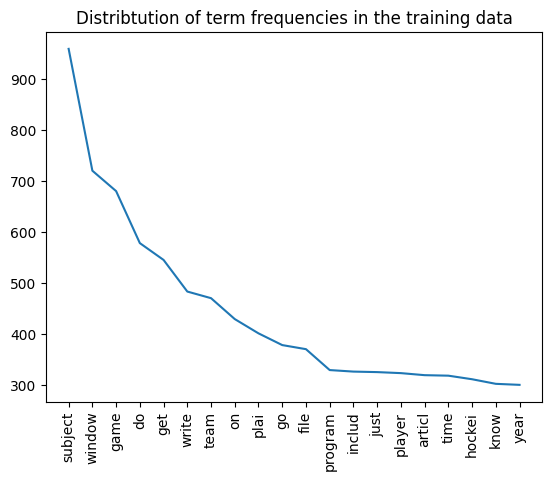

In [127]:
plt.plot(top_20_terms.index, sorted(top_20_terms, reverse=True))
plt.xticks(rotation=90)
plt.title("Distribtution of term frequencies in the training data")

## b.
Create your own K-Nearest-Neighbor classifier function. Your classifier should allow as input the training data matrix, the training labels, the instance to be classified, the value of K (number of neighbors), and should return the predicted class for the instance and the indices of the top K neighbors. Your classifier should work with Euclidean distance as well as Cosine distance (which is 1 minus the Cosine similarity). You may create two separate classifiers, or add the distance metric as a parameter in the classifier function (an example implementation of a KNN classifier was provided in class examples). Show that your classifier works by running it on the first two instances in the test data using both Cosine and Euclidean distance in each case.

In [130]:
train_matrix = np.array(raw_train_matrix.T)
test_matrix = np.array(raw_test_matrix.T)

In [131]:
train_matrix.shape, test_matrix.shape

((800, 5500), (200, 5500))

In [132]:
def knn_search(x, D, K, measure):
    """ find K nearest neighbors of an instance x among the instances in D """
    if measure == 0:
        # euclidean distances from the other points
        dists = np.sqrt(((D - x)**2).sum(axis=1))
    elif measure == 1:
        # first find the vector norm for each instance in D as wel as the norm for vector x
        D_norm = np.array([np.linalg.norm(D[i]) for i in range(len(D))])
        x_norm = np.linalg.norm(x)
        # Compute Cosine: divide the dot product o x and each instance in D by the product of the two norms
        sims = np.dot(D,x)/(D_norm * x_norm)
        # The distance measure will be the inverse of Cosine similarity
        dists = 1 - sims
    idx = np.argsort(dists) # sorting
    # return the indexes of K nearest neighbors
    return idx[:K], dists

In [133]:
train_matrix[0]

array([2., 2., 2., ..., 0., 0., 0.])

In [134]:
test_matrix[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [135]:
train_matrix.shape

(800, 5500)

In [143]:
# test
neigh_idx, distances = knn_search(test_matrix[0], train_matrix, 5, 0)

In [144]:
neigh_idx

array([685, 628, 703, 266, 510])

In [142]:
test_data = test_matrix[:2]

In [145]:
for test in test_data:
  test

In [162]:
type(neigh_labels)

pandas.core.series.Series

In [176]:
print("Measure: Euclidean")
counter = 0
k_neighbors = 3
for test_instance in test_data:
  counter += 1
  # test
  neigh_idx, distances = knn_search(test_instance, train_matrix, k_neighbors, 0)
  # get labels using mode
  neigh_labels = train_labels[1][neigh_idx].mode()[0]
  print(f"Label for instance {counter} is {k_neighbors} neighbors: {neigh_labels}")

Measure: Euclidean
Label for instance 1 is 3 neighbors: 1
Label for instance 2 is 3 neighbors: 0


In [175]:
print("Measure: Cosine")
counter = 0
k_neighbors = 3
for test_instance in test_data:
  counter += 1
  # test
  neigh_idx, distances = knn_search(test_instance, train_matrix, k_neighbors, 1)
  # get labels using mode
  neigh_labels = train_labels[1][neigh_idx].mode()[0]
  print(f"Label for instance {counter} with {k_neighbors} neighbors is: {neigh_labels}")

Measure: Cosine
Label for instance 1 with 3 neighbors is: 1
Label for instance 2 with 3 neighbors is: 0


## c.
Create an evaluation function to measure the accuracy of your classifier. This function will call the classifier function in part a on all the test instances and in each case compares the actual test class label to the predicted class label. It should take as input the training data, the training labels, the test instances, the labels for test instances, and the value of K. Your evaluation function should return the Classification Accuracy (ratio of correct predictions to the number of test instances) [See class notes: Classification & Prediction - Review of Basic Concepts].



In [229]:
def evaluationFunction(train_data, train_labels, test_data, test_labels, k_neighbors, measure=0):
  """
    Function to calculate accuracy ratio of knn_search on all test instances
    args:
      train_data: train data matrix
      train_labels: train data labels
      test_data: test data matrix
      test_labels: test data labels
      k_neighbors: number of neighbors
      measure: measure (cosine or euclidean:default is euclidean)
    return:
      acc_ratio: accuracy ratio (correct predictions/total #)
  """

  correct_predictions = 0
  # loop over test instances
  for idx in range(len(test_data)):
    # get test instance and labels
    test_instance = test_data[idx]
    actual_label = test_labels[idx]

    # apply search (custom knn_search function)
    neigh_idx, distances = knn_search(test_instance, train_data, k_neighbors, measure)
    # get labels using mode
    predict_label = train_labels[neigh_idx].mode()[0]

    # check if the prediction is correct
    if predict_label == actual_label:
      correct_predictions += 1

  # get accuracy ratio
  acc_ratio = correct_predictions / len(test_data)

  return acc_ratio

In [230]:
# test accuracy for k=5
k_neighbors = 5
acc_ratio = evaluationFunction(train_data=train_matrix, train_labels=train_labels[1],
                    test_data=test_matrix, test_labels=test_labels[1],
                    k_neighbors=k_neighbors)
print(f"Classification accuracy for k={k_neighbors}: ", acc_ratio)

Classification accuracy for k=5:  0.815


## d.
Run your evaluation function on a range of values for K from 5 to 100 (in increments of 5) in order to compare accuracy values for different numbers of neighbors. Do this both using Euclidean Distance as well as Cosine similarity measure. Present the results as graphs with K in the x-axis and the evaluation metric (accuracy) on the y-axis. Use a single plot to compare the two version of the classifier (Euclidean distance version vs. cosine similarity version).

In [239]:
# define lists to store acc_ratio
euclidean_acc_ratio, cosine_acc_ratio = [], []

# define measures for distance metric
measures = [0, 1]

# loop over measure
for measure in measures:
  # loop over k_neighbors value
  for k_value in range(5, 101, 5):
    if measure == 0:
      euclidean_acc_ratio.append(evaluationFunction(train_data=train_matrix, train_labels=train_labels[1],
                    test_data=test_matrix, test_labels=test_labels[1],
                    k_neighbors=k_value, measure=measure))
    elif measure == 1:
      cosine_acc_ratio.append(evaluationFunction(train_data=train_matrix, train_labels=train_labels[1],
                    test_data=test_matrix, test_labels=test_labels[1],
                    k_neighbors=k_value, measure=measure))

In [240]:
euclidean_acc_ratio[:3]

[0.815, 0.705, 0.785]

In [241]:
cosine_acc_ratio[:3]

[0.97, 0.975, 0.985]

In [242]:
len(euclidean_acc_ratio), len(cosine_acc_ratio)

(20, 20)

Text(0.5, 1.0, 'Classification accuracy over range of k values')

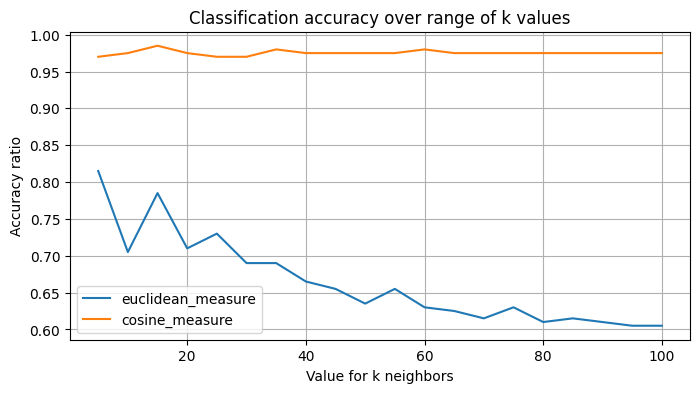

In [244]:
plt.figure(figsize=(8, 4))
plt.plot(range(5, 101, 5), euclidean_acc_ratio, label='euclidean_measure')
plt.plot(range(5, 101, 5), cosine_acc_ratio, label='cosine_measure')
plt.legend()
plt.grid()
plt.xlabel("Value for k neighbors")
plt.ylabel("Accuracy ratio")
plt.title("Classification accuracy over range of k values")

# e
Next, modify the training and test data sets so that term weights are converted to TFxIDF weights (instead of raw term frequencies). [See class notes on Text Categorization]. Then, rerun your evaluation (only for the Cosine similarity version of the classifier) on the range of K values (as above) and create a chart comparing the results with and without using TFxIDF weights.

In [261]:
# we will use standard sklearn methods for tfidf
from sklearn.feature_extraction.text import TfidfTransformer

In [262]:
# initiate tfidf instance
tfidf_vectorizer = TfidfTransformer()

In [270]:
# transform
train_tfidf_matrix = tfidf_vectorizer.fit_transform(train_matrix).toarray()
test_tfidf_matrix = tfidf_vectorizer.fit_transform(test_matrix).toarray()

In [249]:
# # first we'll convert data into tf features
# train_tf_matrix = train_matrix / np.sum(train_matrix, axis=1, keepdims=True)
# test_tf_matrix = test_matrix / np.sum(test_matrix, axis=1, keepdims=True)

In [250]:
# # now, we'll convert tf matrix into idf
# train_idf_matrix = np.log(train_matrix.shape[0] / np.count_nonzero(train_matrix, axis=0))
# test_idf_matrix = np.log(test_matrix.shape[0] / np.count_nonzero(test_matrix, axis=0))

In [252]:
# # now tf-idf matrix
# train_tfidf_matrix = train_tf_matrix * train_idf_matrix
# test_tfidf_matrix = test_tf_matrix * test_idf_matrix

In [269]:
train_tfidf_matrix.toarray()

array([[0.06394986, 0.09550516, 0.09008031, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [275]:
# cosine similarity run with tfidf weights
measure = 1
cosine_tfidf_acc = []
for k_value in range(5, 101, 5):
  cosine_tfidf_acc.append(evaluationFunction(train_data=train_tfidf_matrix, train_labels=train_labels[1],
                      test_data=test_tfidf_matrix, test_labels=test_labels[1],
                      k_neighbors=k_value, measure=measure))

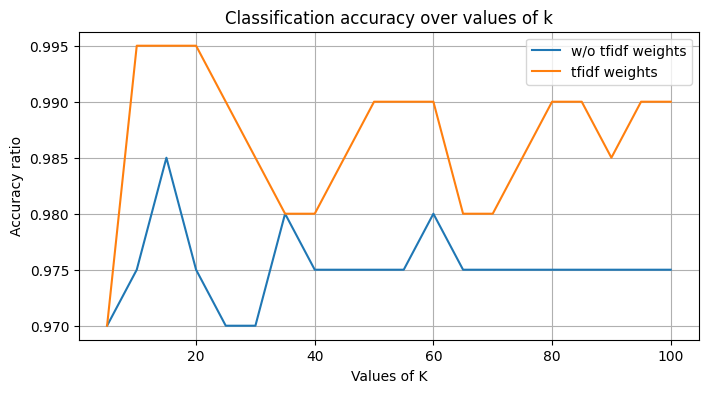

In [276]:
plt.figure(figsize=(8, 4))
plt.plot(range(5, 101, 5), cosine_acc_ratio, label = 'w/o tfidf weights')
plt.plot(range(5, 101, 5), cosine_tfidf_acc, label = 'tfidf weights')
plt.xlabel('Values of K')
plt.ylabel("Accuracy ratio")
plt.title("Classification accuracy over values of k")
plt.grid()
plt.legend()

# f.
Create a new classifier based on the Rocchio Method (also know as the "nearest centroid" method) adapted for text categorization [See class notes on Text Categorization]. You should separate the training function from the classification function. The training part for the classifier can be implemented as a function that takes as input the training data matrix and the training labels, returning the prototype vectors for each class. The classification part can be implemented as another function that would take as input the prototypes returned from the training function and the instance to be classified. This function should measure Cosine similarity of the test instance to each prototype vector. Your output should indicate the predicted class for the test instance and the similarity values of the instance to each of the category prototypes.  Finally, use your evaluation function to compare your results to the best KNN results you obtained in part d. [Note: your functions should work regardless of the number of categories (class labels) and should not be limited to two-class categorization scenario. The number of classes should not be hardcoded in your implementation.]